In [50]:
import pandas as pd
import torch
from transformers import *
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
reviews = pd.read_csv("Amazon_review_data/Reviews.csv")
reviews['ProductId']=reviews['ProductId'].astype(str)
df=reviews[reviews['ProductId']=="B007JFMH8M"]  ## the most popular cookie
df = df.reset_index(drop=True)
df= df[['Id', 'Text', 'Score']]
sentences=df.Text.values
labels= df.Score.values
df.head()

,Id,Text,Score
0,562971,I love these cookies! Not only are they healt...,5
1,562972,Quaker Soft Baked Oatmeal Cookies with raisins...,5
2,562973,I am usually not a huge fan of oatmeal cookies...,5
3,562974,I participated in a product review that includ...,5
4,562975,My kids loved these. I was very pleased to giv...,5


In [3]:
##load the bert model
model = BertModel.from_pretrained('bert-base-uncased') #cache_dir='some path that I want to download the model'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) #output_hidden_states=True, output_attentions=True
# input_ids = torch.tensor([tokenizer.encode("Let's see all hidden-states and attentions on this text")])
# input_ids

13


(array([804.,  90.,  10.,   5.,   2.,   1.,   0.,   0.,   0.,   1.]),
 array([  21. ,  122.6,  224.2,  325.8,  427.4,  529. ,  630.6,  732.2,
         833.8,  935.4, 1037. ]),
 <a list of 10 Patch objects>)

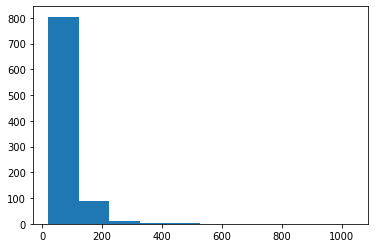

In [4]:
tokens_counts=[len(tokenizer.tokenize(sent)) for sent in sentences]
print(sum(np.array(tokens_counts)>256))
plt.hist(tokens_counts)  ## most texts is shorted than 400 tokens, we select 256 as the max_len of our sequence

In [30]:
input_token_ids=[]
for sent in sentences:
    input_token_ids.append(tokenizer.encode(sent,                         
                            max_length = 256))      # Truncate all sentences.
#                             return_tensors = 'pt'))     # Return pytorch tensors.

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

## tokenize.encode can handle both two steps above, and then add special tokens [start] and [end]
print('Token IDs aftern encoding: ', tokenizer.encode(sentences[0]))

 Original:  I love these cookies!  Not only are they healthy but they taste great and are so soft!  I will definitely add these to my grocery list!
Tokenized:  ['i', 'love', 'these', 'cookies', '!', 'not', 'only', 'are', 'they', 'healthy', 'but', 'they', 'taste', 'great', 'and', 'are', 'so', 'soft', '!', 'i', 'will', 'definitely', 'add', 'these', 'to', 'my', 'grocery', 'list', '!']
Token IDs:  [1045, 2293, 2122, 16324, 999, 2025, 2069, 2024, 2027, 7965, 2021, 2027, 5510, 2307, 1998, 2024, 2061, 3730, 999, 1045, 2097, 5791, 5587, 2122, 2000, 2026, 13025, 2862, 999]
Token IDs aftern encoding:  [101, 1045, 2293, 2122, 16324, 999, 2025, 2069, 2024, 2027, 7965, 2021, 2027, 5510, 2307, 1998, 2024, 2061, 3730, 999, 1045, 2097, 5791, 5587, 2122, 2000, 2026, 13025, 2862, 999, 102]


In [31]:
## max length of the reviews:
print('Max sentence length: ', max([len(sen) for sen in input_token_ids]))
print('Min sentence length: ', min([len(sen) for sen in input_token_ids]))  ##padding has not been added

Max sentence length:  256
Min sentence length:  23


In [41]:
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids=[]
for sent in input_token_ids:
    input_ids.append(F.pad(torch.Tensor(sent), (int((MAX_LEN-len(sent))/2)+(MAX_LEN-len(sent))%2, 
                                                int((MAX_LEN-len(sent))/2)), "constant", 0))
print('\nPadding added done')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Padding added done


In [63]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(torch.Tensor(np.array(att_mask)))

In [64]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=110, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=110, test_size=0.1)
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.stack(train_inputs)  ##convert a list of tensors into a tensor
validation_inputs = torch.stack(validation_inputs)

train_labels = torch.Tensor(train_labels) ## convert an array to a tensor
validation_labels = torch.Tensor(validation_labels)

train_masks = torch.stack(train_masks)
validation_masks = torch.stack(validation_masks)

In [65]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [73]:
BertForSequenceClassification.from_pretrained??

In [74]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [75]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

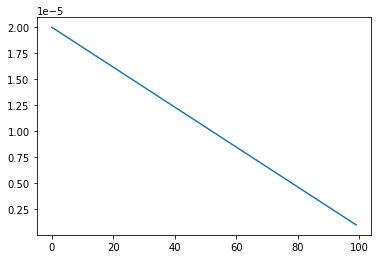

In [134]:
# For the purposes of fine-tuning, the authors recommend choosing from the following values:
# - Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
# - Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
# - Number of epochs: 2, 3, 4  (We'll use 4).
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
#'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps =1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
##plot the lrs
lrs=[]
for i in range(100):
    lrs.append(scheduler.get_lr()) 
    scheduler.step()
plt.plot(range(100), lrs)

In [124]:
test = torch.autograd.Variable(torch.randn([5,5]), requires_grad=True)
optimizer = torch.optim.Adam([test], lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

for i in range(10):
    print(i, lr_scheduler.get_lr())
    lr_scheduler.step()

0 [0.0001]
1 [0.0001]
2 [0.0001]
3 [0.0001]
4 [0.0001]
5 [0.0001]
6 [0.0001]
7 [0.0001]
8 [0.0001]
9 [0.0001]


In [ ]:
##next part: training

In [ ]:
get_linear_schedule_with_warmup

In [77]:
len(train_dataloader)

26

In [80]:
821/32

25.65625

In [79]:
train_inputs.shape

torch.Size([821, 256])

In [57]:
x=torch.stack(train_inputs)
x.shape

torch.Size([821, 256])

In [55]:
validation_inputs = torch.tensor(validation_inputs)

ValueError: only one element tensors can be converted to Python scalars

In [32]:
torch.Tensor(input_token_ids[0])

tensor([  101.,  1045.,  2293.,  2122., 16324.,   999.,  2025.,  2069.,  2024.,
         2027.,  7965.,  2021.,  2027.,  5510.,  2307.,  1998.,  2024.,  2061.,
         3730.,   999.,  1045.,  2097.,  5791.,  5587.,  2122.,  2000.,  2026.,
        13025.,  2862.,   999.,   102.])

In [17]:
test=input_token_ids[0]
F.pad(test, )

torch.Size([1, 31])

In [26]:
int((256-31)/2)

112

In [29]:
t4d = torch.rand([1,31])
p1d = (int((256-31)/2)+1,int((256-31)/2)) # pad last dim by 1 on each side
out = F.pad(t4d, p1d, "constant", 0)  # effectively zero padding
print(out.data.size())

torch.Size([1, 256])


In [23]:
F.pad??